# Notebook used to create plots for the MA
In this notebook we create some plots that were used in the Thesis for showing

In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from PIL import Image
import datetime
from utils.plotting import showFlow, overlaySegment
from utils.encoding import dice_coeff, hausdorff_dist
from utils.load_models import load_flownet2, load_pwcnet
from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.layers import warp
import time

import warnings
warnings.filterwarnings('ignore')

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7efd7b683880>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [30]:
disp_hw = 5
displace_range = 11
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                 (1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2).cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2).cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),
                                (1, 1, grid_size, grid_size)).view(1, -1, 1,
                                                                   2).cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1 = F.relu(self.batch2(self.layer2(x_1)))
        features_fixed = self.layer3(x_1)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2 = F.relu(self.batch2(self.layer2(x_2)))
        features_moving = self.layer3(x_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return soft_cost, disp_xy


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, displace_range ** 2, H, W)

        return ssd_distance

In [3]:
# load a model
path_to_state_dict = "models/Experiment_2/fineTuneSoft/tuned.pth"
model = OBELISK2d(16)
model.load_state_dict(torch.load(path_to_state_dict))
model.eval().cuda()

OBELISK2d(
  (layer0): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [110]:
# Load images and segmentations from a specific ID

prob_id = '717'
path_to_data = "/share/data_ultraschall/compressions"
frame_path = os.path.join(path_to_data,str(prob_id),'frames')
seg_path = os.path.join(path_to_data,str(prob_id),'segmentations','1')

frame_list = []
for frame in os.listdir(frame_path):
    frame_list.append(os.path.join(frame_path,frame))
frame_list.sort()

seg_list = []
for seg in os.listdir(seg_path):
    seg_list.append(os.path.join(seg_path,seg))
seg_list.sort()

assert len(frame_list) == len(seg_list)
frames = torch.zeros([len(frame_list), 150,150])
segs = torch.zeros([len(frame_list), 150,150])
# read images
for i in range(len(frame_list)):
    frames[i] = torch.from_numpy(np.array(Image.open(frame_list[i]))) / 255.
    segs[i] = torch.from_numpy(np.array(Image.open(seg_list[i]))) / 100

In [111]:
landmarks = pd.read_csv('landmarks.csv')
start_frame = landmarks[landmarks['Id']== int(prob_id)]['Start Frames'].iat[0]
start = int(start_frame.split('[')[1].split(']')[0])
start

68

In [112]:
# set font and size so they are readable in the thesis
fonts = {'fontsize': 22,'family': 'Latin Modern Roman'}

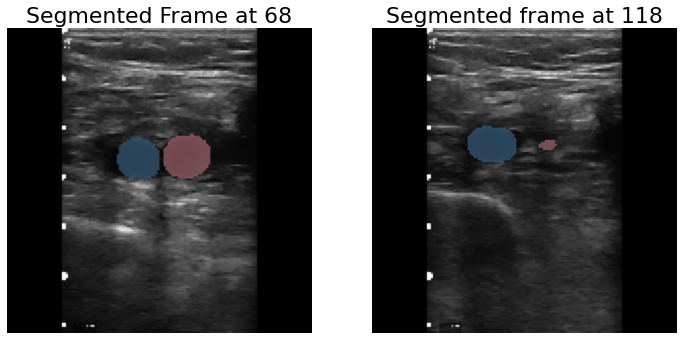

In [121]:
idx = start+50

fig, ax = plt.subplots(1,2, figsize=(12,8))
ax[0].imshow(overlaySegment(frames[start], segs[start]))
ax[0].axis('off')
ax[0].set_title(f'Segmented Frame at {start}', fontdict=fonts)
ax[1].imshow(overlaySegment(frames[idx], segs[idx]))
ax[1].axis('off')
ax[1].set_title(f'Segmented frame at {idx}', fontdict=fonts)
plt.show()

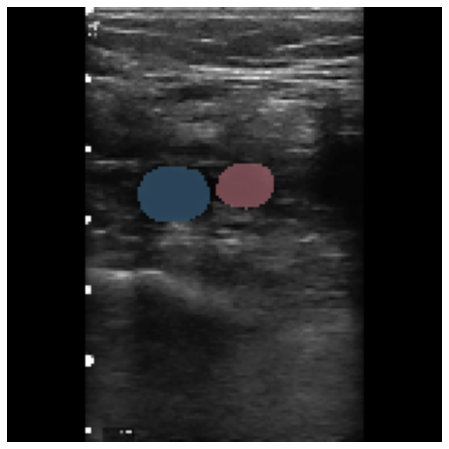

In [122]:
fig = plt.figure(figsize=(12,8))
plt.imshow(overlaySegment(frames[idx+10], segs[idx+10]), cmap='gray')
plt.axis('off')
plt.show()

In [123]:
fixed = frames[start]
moving= frames[idx]

soft, flow = model(moving.unsqueeze(0).unsqueeze(0).cuda(), fixed.unsqueeze(0).unsqueeze(0).cuda())
disp_xy = F.interpolate(flow.detach().cpu(), size=(150,150), mode='bicubic')

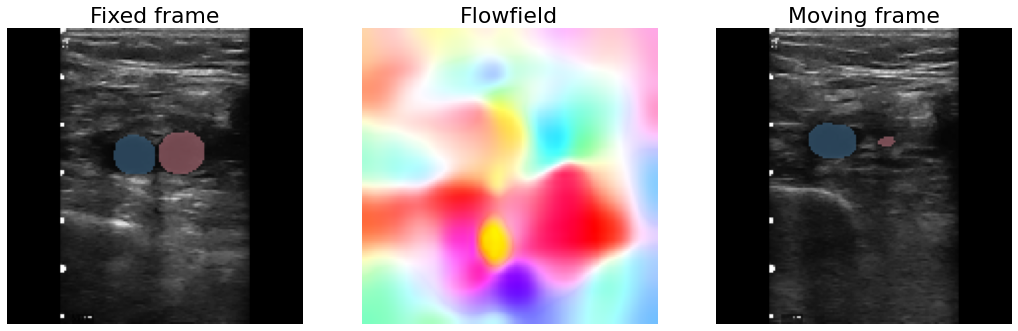

In [124]:
fig, axs = plt.subplots(1,3,figsize=(18,9))
axs[0].imshow(overlaySegment(fixed, segs[start]), cmap='gray')
axs[0].axis('off')
axs[0].set_title('Fixed frame', fontdict=fonts)

axs[1].imshow(showFlow(disp_xy))
axs[1].axis('off')
axs[1].set_title('Flowfield', fontdict=fonts)

axs[2].imshow(overlaySegment(moving, segs[idx]), cmap='gray')
axs[2].axis('off')
axs[2].set_title('Moving frame', fontdict=fonts)

plt.show()